In [8]:
import torch
import torch.autograd as autograd # torch中自动计算梯度模块
import torch.nn as nn             # 神经网络模块
import torch.nn.functional as F   # 神经网络模块中的常用功能 
import torch.optim as optim       # 模型优化器模块
import numpy as np
import pandas as pd
torch.manual_seed(1)
%matplotlib inline

,confirmed,negative,time
0,-0.605428,-0.865846,1
1,-0.605378,-0.865683,3
2,-0.605378,-0.865380,2
3,-0.605378,-0.864647,4
4,-0.605378,-0.863949,5
...,...,...,...
80,2.368169,2.074523,81
81,2.484052,2.172225,82
82,2.590574,2.257443,83
83,2.700811,2.362974,84


In [76]:

def load_data():
    # passengers number of international airline , 1949-01 ~ 1960-12 per month
    with open("data/UK_data.csv") as dataSource:
        seqcsv = pd.read_csv(dataSource)
    seq = seqcsv[['confirmed', 'negative']]
    # normalization
    seq = (seq - seq.mean(axis=0)) / seq.std(axis=0)
    seq['time'] = seqcsv['id']
    return seq.to_numpy()

In [77]:
load_data()

array([[-6.05427903e-01, -8.65845752e-01,  1.00000000e+00],
       [-6.05378369e-01, -8.65682878e-01,  3.00000000e+00],
       [-6.05378369e-01, -8.65380397e-01,  2.00000000e+00],
       [-6.05378369e-01, -8.64647463e-01,  4.00000000e+00],
       [-6.05378369e-01, -8.63949430e-01,  5.00000000e+00],
       [-6.05378369e-01, -8.62902381e-01,  6.00000000e+00],
       [-6.05378369e-01, -8.62297420e-01,  7.00000000e+00],
       [-6.05353602e-01, -8.61168934e-01,  8.00000000e+00],
       [-6.05353602e-01, -8.60540705e-01,  1.00000000e+01],
       [-6.05353602e-01, -8.59772869e-01,  9.00000000e+00],
       [-6.05328835e-01, -8.58516410e-01,  1.10000000e+01],
       [-6.05229768e-01, -8.54851739e-01,  1.20000000e+01],
       [-6.05229768e-01, -8.52013073e-01,  1.70000000e+01],
       [-6.05229768e-01, -8.47359523e-01,  1.30000000e+01],
       [-6.05205002e-01, -8.38494509e-01,  1.40000000e+01],
       [-6.05205002e-01, -8.33340702e-01,  1.60000000e+01],
       [-6.05205002e-01, -8.33014954e-01

In [72]:
class RegLSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, mid_dim, mid_layers):
        super(RegLSTM, self).__init__()

        self.rnn = nn.LSTM(inp_dim, mid_dim, mid_layers)  # rnn
        self.reg = nn.Sequential(
            nn.Linear(mid_dim, mid_dim),
            nn.Tanh(),
            nn.Linear(mid_dim, out_dim),
        )  # regression

    def forward(self, x):
        y = self.rnn(x)[0]  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.shape
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y

    def output_y_hc(self, x, hc):
        y, hc = self.rnn(x, hc)  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.size()
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y, hc

In [85]:
def run_train_lstm():
    inp_dim = 3
    out_dim = 1
    mid_dim = 8
    mid_layers = 1
    batch_size = 12 * 4
    mod_dir = '.'

    '''load data'''
    data = load_data()
    data_x = data[:-1, :]
    data_y = data[+1:, 0]
    assert data_x.shape[1] == inp_dim

    train_size = int(len(data_x) * 0.75)

    train_x = data_x[:train_size]
    train_y = data_y[:train_size]
    train_x = train_x.reshape((train_size, inp_dim))
    train_y = train_y.reshape((train_size, out_dim))

    '''build model'''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = RegLSTM(inp_dim, out_dim, mid_dim, mid_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

    '''train'''
    var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
    var_y = torch.tensor(train_y, dtype=torch.float32, device=device)

    batch_var_x = list()
    batch_var_y = list()

    for i in range(batch_size):
        j = train_size - i
        batch_var_x.append(var_x[j:])
        batch_var_y.append(var_y[j:])

    from torch.nn.utils.rnn import pad_sequence
    batch_var_x = pad_sequence(batch_var_x)
    batch_var_y = pad_sequence(batch_var_y)

    with torch.no_grad():
        weights = np.tanh(np.arange(len(train_y)) * (np.e / len(train_y)))
        weights = torch.tensor(weights, dtype=torch.float32, device=device)

    print("Training Start")
    for e in range(500):
        out = net(batch_var_x)
    
        # loss = criterion(out, batch_var_y)
        loss = (out - batch_var_y) ** 2 * weights
        loss = loss.mean()
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if e % 64 == 0:
            print('Epoch: {:4}, Loss: {:.5f}'.format(e, loss.item()))
    torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))
    print("Save in:", '{}/net.pth'.format(mod_dir))

    '''eval'''
    net.load_state_dict(torch.load('{}/net.pth'.format(mod_dir), map_location=lambda storage, loc: storage))
    net = net.eval()

    test_x = data_x.copy()
    test_x[train_size:, 0] = 0
    test_x = test_x[:, np.newaxis, :]
    test_x = torch.tensor(test_x, dtype=torch.float32, device=device)

    '''simple way but no elegant'''
    # for i in range(train_size, len(data) - 2):
    #     test_y = net(test_x[:i])
    #     test_x[i, 0, 0] = test_y[-1]

    '''elegant way but slightly complicated'''
    eval_size = 1
    zero_ten = torch.zeros((mid_layers, eval_size, mid_dim), dtype=torch.float32, device=device)
    test_y, hc = net.output_y_hc(test_x[:train_size], (zero_ten, zero_ten))
    test_x[train_size + 1, 0, 0] = test_y[-1]
    for i in range(train_size + 1, len(data) - 2):
        test_y, hc = net.output_y_hc(test_x[i:i + 1], hc)
        test_x[i + 1, 0, 0] = test_y[-1]
    pred_y = test_x[1:, 0, 0]
    pred_y = pred_y.cpu().data.numpy()

    diff_y = pred_y[train_size:] - data_y[train_size:-1]
    l1_loss = np.mean(np.abs(diff_y))
    l2_loss = np.mean(diff_y ** 2)
    print("L1: {:.3f}    L2: {:.3f}".format(l1_loss, l2_loss))

    plt.plot(pred_y, 'r', label='pred')
    plt.plot(data_y, 'b', label='real', alpha=0.3)
    plt.plot([train_size, train_size], [-1, 2], color='k', label='train | pred')
    plt.legend(loc='best')
    plt.savefig('lstm_reg.png')
    plt.pause(4)

Training Start
Epoch:    0, Loss: 0.13552
Epoch:   64, Loss: 0.01252
Epoch:  128, Loss: 0.00074
Epoch:  192, Loss: 0.00021
Epoch:  256, Loss: 0.00010
Epoch:  320, Loss: 0.00008
Epoch:  384, Loss: 0.00007
Epoch:  448, Loss: 0.00006
Save in: ./net.pth
L1: 1.025    L2: 1.506


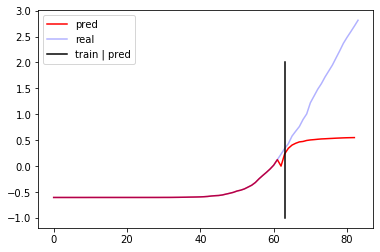

In [86]:
run_train_lstm()